In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

import xlrd
import csv
import pandas as pd
import json

Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #2.
Duplicate key in file '/home/ubuntu/.config/matplotlib/matplotlibrc' line #3.


# SUZUKI

In [2]:
# Load prediction
pred = pickle.load(open("nfp/pred.pkl", "rb")) 
gt = pickle.load(open("nfp/gt.pkl", "rb"))
test_ids = json.load(open("nfp/test_ids.json", "r"))

num_class = 119

In [3]:
# load data
test_data = pd.read_csv('data/suzuki_type_test_v2.csv', delimiter=';')

In [4]:
test_data

,Reactant1,Reactant2,Product,Yield,M,L,B,S,A,id
0,COC(=O)C1=CC=CC=C1NC(=O)CCC1=CC=C(I)C=C1,COC1=CC(F)=C(C=C1)B(O)O,COC1=CC=C(C(F)=C1)C1=CC=C(CCC(=O)NC2=CC=CC=C2C...,0.10,[1],[28],[55],"[94, 89, 87]",[],9
1,OB(O)C1=CC=C(Cl)C=C1,CC1=NC(N)=NC(NC2=CC(Cl)=CC(Br)=C2)=C1,CC1=NC(N)=NC(NC2=CC(Cl)=CC(=C2)C2=CC=C(Cl)C=C2...,0.72,[1],[28],[52],"[94, 90]",[],29
2,OB(O)C1=CC=C(Cl)C(=C1)C(F)(F)F,CC1=NC(N)=NC(NC2=CC(Cl)=CC(Br)=C2)=C1,CC1=NC(N)=NC(NC2=CC(Cl)=CC(=C2)C2=CC(=C(Cl)C=C...,0.67,[1],[28],[52],"[94, 90]",[],30
3,CC(C)[C@@]1(CC(C)(C)O)CCN([C@@H](C)C2=CC=C(C=C...,CC1=NN2C=C(Br)C=CC2=N1,CC(C)[C@@]1(CC(C)(C)O)CCN([C@@H](C)C2=CC=C(C=C...,0.30,[0],[],[55],"[94, 90, 90, 87]",[],66
4,OB(O)C1=CC(=CC=C1)C#N,CN1N=C(OS(=O)(=O)C(F)(F)F)C=C1C1=CC=C(F)C=C1,CN1N=C(C=C1C1=CC=C(F)C=C1)C1=CC(=CC=C1)C#N,0.48,[0],[],"[52, 57]","[94, 92, 94, 92]",[],101
...,...,...,...,...,...,...,...,...,...,...
14537,ClC1=NN=C(Cl)N=N1,CC1(C)OB(OC1(C)C)C#CC1=CC=CC=C1,CC1(C)OB(OC1(C)C)C1=C(Cl)N=NC(Cl)=C1C1=CC=CC=C1,0.80,[],[],[],[],[],145320
14538,BrC1=CC(=O)CCC1,CC1(C)OB(OC1(C)C)C1=CC2=C(C=C1)N=CC=C2,O=C1CCCC(=C1)C1=CC2=CC=CN=C2C=C1,0.88,[],[],[],[],[],145346
14539,CCC1=CC=C(C=C1)B(O)O,BrC1=CC=C(S1)S(=O)(=O)N1C=CC=C1,CCC1=CC=C(C=C1)C1=CC=C(S1)S(=O)(=O)N1C=CC=C1,0.81,[],[],[],[],[],145350
14540,CCCCN(CCO)CCO,CC(C)OB(OC(C)C)C1=CC=C(Cl)C=C1Br,CCCC[N]12CCO[B]1(OCC2)C1=C(Br)C=C(Cl)C=C1,0.92,[],[],[],[],[],145362


In [5]:
reagent_dict = dict()
num_dicts = {'M': 28, 'L': 23, 'B': 35, 'S': 10, 'A': 17}
unique_i = 0
boundaries = []
for key, num_r in num_dicts.items():
    for ii in range(num_r):
        reagent_dict[key+str(ii+1)] = unique_i
        unique_i += 1
    boundaries.append(unique_i)
null_ids = [114, 115, 116, 117, 118]
other_id = 113

In [6]:
print(boundaries)

[28, 51, 86, 96, 113]


In [7]:
# Metric: pick top-1/5 reagents from each categorized reagent
predictions = []

num_ranks = 5

for i in range(len(gt)):
    i_id = int(test_ids[str(i)][1:-2])
    i_pred = {'id': i_id}
    
    gt_idx = {'M': [], 'L': [], 'B': [], 'S': [], 'A': [], 'other': []}
    pred_rank = {'M': [], 'L': [], 'B': [], 'S': [], 'A': [], 'other': []}

    ids = np.where(gt[i][0] == 1)[0]
    
    Ms = ids[(ids < boundaries[0]) | (ids == null_ids[0])]
    Ls = ids[(boundaries[0] <= ids) & (ids < boundaries[1]) | (ids == null_ids[1])]
    Bs = ids[(boundaries[1] <= ids) & (ids < boundaries[2]) | (ids == null_ids[2])]
    Ss = ids[(boundaries[2] <= ids) & (ids < boundaries[3]) | (ids == null_ids[3])]
    As = ids[(boundaries[3] <= ids) & (ids < boundaries[4]) | (ids == null_ids[4])]
    other = ids[(ids == other_id)]
    
    gt_idx['M'] = [x for x in Ms]
    gt_idx['L'] = [x for x in Ls]
    gt_idx['B'] = [x for x in Bs]
    gt_idx['S'] = [x for x in Ss]
    gt_idx['A'] = [x for x in As]
    
    gt_idx['M'] = [x + 1 if x != null_ids[0] else num_dicts['M']+1 for x in gt_idx['M']]
    gt_idx['L'] = [x + 1-boundaries[0] if x != null_ids[1] else num_dicts['L']+1 for x in gt_idx['L']]
    gt_idx['B'] = [x + 1-boundaries[1] if x != null_ids[2] else num_dicts['B']+1 for x in gt_idx['B']]
    gt_idx['S'] = [x + 1-boundaries[2] if x != null_ids[3] else num_dicts['S']+1 for x in gt_idx['S']]
    gt_idx['A'] = [x + 1-boundaries[3] if x != null_ids[4] else num_dicts['A']+1 for x in gt_idx['A']]
    
    gt_idx['other'] = [x for x in other]
        
    pred_Ms = pred[i][:boundaries[0]]
    pred_Ms = np.append(pred_Ms, pred[i][null_ids[0]])
    pred_Ls = pred[i][boundaries[0]:boundaries[1]]
    pred_Ls = np.append(pred_Ls, pred[i][null_ids[1]])
    pred_Bs = pred[i][boundaries[1]:boundaries[2]]
    pred_Bs = np.append(pred_Bs, pred[i][null_ids[2]])
    pred_Ss = pred[i][boundaries[2]:boundaries[3]]
    pred_Ss = np.append(pred_Ss, pred[i][null_ids[3]])
    pred_As = pred[i][boundaries[3]:boundaries[4]]
    pred_As = np.append(pred_As, pred[i][null_ids[4]])
    
    pred_rank['M'] = np.argsort(pred_Ms)[-num_ranks:][::-1]
    pred_rank['L'] = np.argsort(pred_Ls)[-num_ranks:][::-1] + boundaries[0]
    pred_rank['B'] = np.argsort(pred_Bs)[-num_ranks:][::-1] + boundaries[1]
    pred_rank['S'] = np.argsort(pred_Ss)[-num_ranks:][::-1] + boundaries[2]
    pred_rank['A'] = np.argsort(pred_As)[-num_ranks:][::-1] + boundaries[3]
    
    # Null class.............
    if boundaries[0] in pred_rank['M']:
        pred_rank['M'] = [null_ids[0] if x == boundaries[0] else x for x in pred_rank['M']]
    
    if boundaries[1] in pred_rank['L']:
        pred_rank['L'] = [null_ids[1] if x == boundaries[1] else x for x in pred_rank['L']]
    
    if boundaries[2] in pred_rank['B']:
        pred_rank['B'] = [null_ids[2] if x == boundaries[2] else x for x in pred_rank['B']]
    
    if boundaries[3] in pred_rank['S']:
        pred_rank['S'] = [null_ids[3] if x == boundaries[3] else x for x in pred_rank['S']]
        
    if boundaries[4] in pred_rank['A']:
        pred_rank['A'] = [null_ids[4] if x == boundaries[4] else x for x in pred_rank['A']]
        
    pred_rank['M'] = [x + 1 if x != null_ids[0] else num_dicts['M']+1 for x in pred_rank['M']]
    pred_rank['L'] = [x + 1-boundaries[0] if x != null_ids[1] else num_dicts['L']+1 for x in pred_rank['L']]
    pred_rank['B'] = [x + 1-boundaries[1] if x != null_ids[2] else num_dicts['B']+1 for x in pred_rank['B']]
    pred_rank['S'] = [x + 1-boundaries[2] if x != null_ids[3] else num_dicts['S']+1 for x in pred_rank['S']]
    pred_rank['A'] = [x + 1-boundaries[3] if x != null_ids[4] else num_dicts['A']+1 for x in pred_rank['A']]
        
    # Other class needs thresholding
    other_score = pred[i][other_id]
    pred_rank['other'] = []
    if other_score > -5:
        pred_rank['other'].append(other_id)
        
    i_pred['pred'] = pred_rank
    i_pred['gt'] = gt_idx
    
    predictions.append(i_pred)

In [9]:
def myconverter(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, datetime.datetime):
        return obj.__str__()

with open("nfp_suzuki_prediction.json", "w") as write_file:
    json.dump(predictions, write_file, default=myconverter)

In [11]:
from evaluate import accuracy, compute_PR

In [12]:
data_file = json.load(open("nfp_suzuki_prediction.json", "r"))
# type_count = {'M': 45, 'L': 48, 'B': 14, 'S': 23, 'A': 75} #, 'other': 1}  # CN
type_count = {'M': 29, 'L': 24, 'B': 36, 'S': 11, 'A': 18}  # suzuki
# type_count = {'M': 33, 'L': 21, 'T': 9, 'S': 11, 'A': 31} #, 'other': 1} neigishi
# type_count = {'M': 19, 'L': 7, 'T': 8, 'S': 16, 'A': 12, 'G': 1, 'O': 14, 'P': 5, 'other': 1}
top1_acc, topk_acc = accuracy(data_file, type_count)

result = compute_PR(data_file, type_count)

Top 1 accuracy for type  M  : 0.5762617859123683
Top k accuracy for type  M  : 0.819814198557959
Top 1 accuracy for type  L  : 0.884706045479756
Top k accuracy for type  L  : 0.9541735995562951
Top 1 accuracy for type  B  : 0.4636716583471991
Top k accuracy for type  B  : 0.7795341098169717
Top 1 accuracy for type  S  : 0.6656267332224071
Top k accuracy for type  S  : 0.8484470327232391
Top 1 accuracy for type  A  : 0.9559761508596784
Top k accuracy for type  A  : 0.990363283416528


In [38]:
print(result[0][2])
print(result[1][2])

print(result[0][3])
print(result[1][3])

print(result[0][4])
print(result[1][4])

print(result[0][5])
print(result[1][5])

{'M': 0.022641509433962266, 'L': 0.12560646900269543, 'T': 0.045072115384615384, 'S': 0.0272383181511471, 'A': 0.05754716981132075, 'G': 0.9473684210526315, 'O': 0.0646900269541779, 'P': 0.16634615384615387, 'other': 0.2631578947368421, 'all': 0.06920852380571096}
{'M': 0.041725281330283165, 'L': 0.13154680060092175, 'T': 0.09008077273190232, 'S': 0.04887293353576248, 'A': 0.08222525123282322, 'G': 0.9473684210526315, 'O': 0.06800359934669765, 'P': 0.19534833091436865, 'other': 0.2631578947368421, 'all': 0.08846075233636402}
{'M': 0.05263157894736842, 'L': 0.14285714285714285, 'T': 0.10533707865168539, 'S': 0.06060376213592233, 'A': 0.08333333333333333, 'G': 0.2037735849056604, 'O': 0.07142857142857142, 'P': 0.1572727272727273, 'other': 0.05660377358490566, 'all': 0.08263973274990895}
{'M': 0.1698483496877788, 'L': 0.336734693877551, 'T': 0.3283603344656389, 'S': 0.16308351922094255, 'A': 0.3095029239766082, 'G': 0.2037735849056604, 'O': 0.20408163265306123, 'P': 0.5647058823529412, 'o

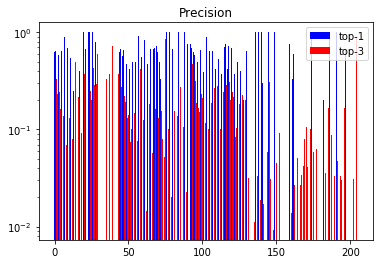

In [7]:
# Metal
ax = plt.subplot(111)
x_range = [i-0.2 for i in range(0, len(result[0][0].keys()))]
x_range2 = [i+0.2 for i in range(0, len(result[1][0].keys()))]
ax.bar(x_range, result[0][0].values(), width=0.4, color='b', align='center')
# ax.bar(x, z, width=0.2, color='g', align='center')
ax.bar(x_range2, result[1][0].values(), width=0.4, color='r', align='center')
# ax.xaxis_date()
ax.set_yscale('log')

plt.legend(['top-1', 'top-3'])
plt.title("Precision")
plt.show()